In [35]:
from __future__ import absolute_import
from __future__ import division
from __future__ import print_function

import datetime
import os
import pandas as pd
import numpy as np
import pkg_resources
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import time
import scipy.stats as stats
from sklearn import metrics

%matplotlib inline

# autoreload makes it easier to interactively work on code in imported libraries
%load_ext autoreload
%autoreload 2

# Set pandas display options so we can read more of the comment text.
pd.set_option('max_colwidth', 300)

import model_bias_analysis

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [7]:
# Print python version
import sys
print(sys.version)

2.7.13 (default, Nov 24 2017, 17:33:09) 
[GCC 6.3.0 20170516]


# Load and pre-process Madlibs data

In [8]:
# Read madlibs dataset, convert Label to Booleans
madlibs_df = pd.read_csv('eval_datasets/bias_madlibs_77k_scored_prod_models.csv')
madlibs_df.loc[madlibs_df.Label == 'BAD', 'Label'] = True
madlibs_df.loc[madlibs_df.Label == 'NOT_BAD', 'Label'] = False
# Needed for AUC metrics to work properly
madlibs_df['Label'] = madlibs_df['Label'].astype(bool)

In [9]:
# Add boolean identity columns, e.g. "hug american" should have True in the "american" column.
madlibs_identity_terms = model_bias_analysis.read_identity_terms('bias_madlibs_data/adjectives_people.txt')
model_bias_analysis.add_subgroup_columns_from_text(madlibs_df, 'Text', madlibs_identity_terms)
madlibs_df.head()

,Label,Template,Text,id,RockV6_2:TOXICITY,Rock:TOXICITY,lesbian,gay,bisexual,transgender,...,older,young,younger,teenage,millenial,middle aged,elderly,blind,deaf,paralyzed
0,True,verb_adj,murder american,0,0.837852,0.811245,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
1,False,verb_adj,respect trans,1,0.066053,0.251806,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
2,False,verb_adj,respect homosexual,2,0.188938,0.831167,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
3,False,verb_adj,hug mexican,3,0.059981,0.098826,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
4,True,verb_adj,kill sikh,4,0.743793,0.888041,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False


# Load and pre-process Civil Comments data

In [10]:
def convert_to_bool_column(df, src_column, dst_column):
    df.loc[df[src_column] >= 0.5, dst_column] = True
    df.loc[df[src_column] < 0.5, dst_column] = False
    # convert NaNs to False
    df.loc[df[src_column].isnull(), dst_column] = False
    # Needed for AUC metrics to work properly
    df[dst_column] = df[dst_column].astype(bool)

In [11]:
# Read Civil Comments dataset, set Label column to be a Boolean toxicity value.
civil_comments_df = pd.read_csv('eval_datasets/civil_comments_scored_prod_models.csv')
convert_to_bool_column(civil_comments_df, 'toxicity', 'Label')

In [12]:
# Convert identity terms to booleans
civil_comments_identity_terms = [
    'male', 'female', 'transgender', 'other_gender', 'heterosexual',
    'homosexual_gay_or_lesbian', 'bisexual', 'other_sexual_orientation', 'christian',
    'jewish', 'muslim', 'hindu', 'buddhist', 'atheist', 'other_religion', 'black',
    'white', 'asian', 'latino', 'other_race_or_ethnicity',
    'physical_disability', 'intellectual_or_learning_disability',
    'psychiatric_or_mental_illness', 'other_disability']
for identity in civil_comments_identity_terms:
    convert_to_bool_column(civil_comments_df, identity, identity)
civil_comments_df.head()
    

,Unnamed: 0,Unnamed: 0.1,Unnamed: 0.1.1,article_id,asian,atheist,bisexual,black,buddhist,christian,...,sexual_explicit,threat,toxicity,toxicity_annotator_count,transgender,white,wow,Rock:TOXICITY,RockV6_2:TOXICITY,Label
0,0,0,0,138380,False,False,False,False,False,False,...,0.000000,0.000000,0.783333,60,False,False,0,0.623230,0.865134,True
1,1,1,1,160937,False,False,False,False,False,False,...,0.000000,0.000000,0.628571,70,False,False,0,0.773702,0.831807,True
2,2,2,2,366992,False,False,False,False,False,False,...,0.028571,0.014286,0.571429,70,False,False,0,0.544393,0.607978,True
3,3,3,3,351749,False,False,False,False,False,False,...,0.000000,0.000000,0.675000,80,False,False,0,0.683339,0.869096,True
4,4,4,4,147521,False,False,False,False,False,False,...,0.000000,0.413333,0.800000,75,False,False,0,0.876304,0.836591,True


In [13]:
# Create another view of the data that is limited to the comments < 100 characters.
civil_comments_short_df = civil_comments_df.loc[civil_comments_df['Text'].str.len() < 100]

# Measure bias

In [14]:
# Calculate bias metrics on each dataset
madlibs_bias_metrics = model_bias_analysis.compute_bias_metrics_for_models(
    madlibs_df,
    madlibs_identity_terms,
    ['Rock:TOXICITY', 'RockV6_2:TOXICITY'],
    'Label')
civil_comments_bias_metrics = model_bias_analysis.compute_bias_metrics_for_models(
    civil_comments_df,
    civil_comments_identity_terms,
    ['Rock:TOXICITY', 'RockV6_2:TOXICITY'],
    'Label')

In [15]:
civil_comments_short_bias_metrics = model_bias_analysis.compute_bias_metrics_for_models(
    civil_comments_short_df,
    civil_comments_identity_terms,
    ['Rock:TOXICITY', 'RockV6_2:TOXICITY'],
    'Label')

value error!!! Only one class present in y_true. ROC AUC score is not defined in that case. 
value error!!! Only one class present in y_true. ROC AUC score is not defined in that case. 
value error!!! Only one class present in y_true. ROC AUC score is not defined in that case. 
value error!!! Only one class present in y_true. ROC AUC score is not defined in that case. 
value error!!! Only one class present in y_true. ROC AUC score is not defined in that case. 
value error!!! Only one class present in y_true. ROC AUC score is not defined in that case. 
value error!!! Only one class present in y_true. ROC AUC score is not defined in that case. 
value error!!! Only one class present in y_true. ROC AUC score is not defined in that case. 
value error!!! Only one class present in y_true. ROC AUC score is not defined in that case. 
value error!!! Only one class present in y_true. ROC AUC score is not defined in that case. 
value error!!! Only one class present in y_true. ROC AUC score is not 

In [16]:
# Sort bias metrics by weighted pinned AUC
def sort_by_weighted_pinned_auc(bias_metrics):
    bias_metrics['weighted_pinned_auc'] = (
        bias_metrics['Rock:TOXICITY_bnsp_auc'] +
        bias_metrics['Rock:TOXICITY_bpsn_auc'] +
        bias_metrics['Rock:TOXICITY_subgroup_auc']) / 3
    bias_metrics = bias_metrics.sort_values('weighted_pinned_auc', ascending=True)
    return bias_metrics.drop('weighted_pinned_auc', axis=1)

madlibs_bias_metrics = sort_by_weighted_pinned_auc(madlibs_bias_metrics)
civil_comments_bias_metrics = sort_by_weighted_pinned_auc(civil_comments_bias_metrics)
civil_comments_short_bias_metrics = sort_by_weighted_pinned_auc(civil_comments_short_bias_metrics)

In [17]:
civil_comments_short_bias_metrics

,Rock:TOXICITY_bnsp_auc,Rock:TOXICITY_bpsn_auc,Rock:TOXICITY_negative_aeg,Rock:TOXICITY_positive_aeg,Rock:TOXICITY_subgroup_auc,subgroup,subset_size,RockV6_2:TOXICITY_bnsp_auc,RockV6_2:TOXICITY_bpsn_auc,RockV6_2:TOXICITY_negative_aeg,RockV6_2:TOXICITY_positive_aeg,RockV6_2:TOXICITY_subgroup_auc
5,0.981018,0.574589,0.432685,0.105010,0.705605,homosexual_gay_or_lesbian,743,0.927494,0.824487,0.297307,-0.078862,0.768287
21,0.834910,0.913476,0.289715,-0.238664,0.571429,intellectual_or_learning_disability,11,0.816865,0.831496,0.291579,-0.234149,0.535714
4,0.936999,0.727653,0.342266,-0.027626,0.721014,heterosexual,58,0.934094,0.874530,0.211589,-0.189727,0.793478
2,0.924908,0.823183,0.336985,-0.174747,0.740532,transgender,183,0.895972,0.889983,0.269538,-0.178842,0.768658
15,0.945123,0.785825,0.354367,-0.047339,0.765804,black,1054,0.968965,0.754640,0.399983,-0.021438,0.775819
22,0.950433,0.786838,0.358592,-0.053193,0.781171,psychiatric_or_mental_illness,495,0.950900,0.858471,0.286049,-0.065712,0.838466
16,0.941012,0.807950,0.331320,-0.055697,0.783766,white,2230,0.959880,0.830020,0.372516,-0.080897,0.817256
10,0.941178,0.812724,0.335553,-0.064606,0.782752,muslim,1624,0.929436,0.882686,0.264886,-0.130706,0.812552
9,0.952931,0.793307,0.339744,-0.026733,0.794870,jewish,393,0.949480,0.840675,0.329010,-0.070221,0.807151
6,0.936755,0.821174,0.328169,-0.082697,0.825000,bisexual,18,0.911440,0.908253,0.178779,-0.182233,0.837500


In [60]:
# Define functions for printing bias metric heatmaps
def limit_subgroups(bias_metrics, subgroups):
    return bias_metrics.loc[bias_metrics.subgroup.isin(subgroups)]

def print_auc_heatmap(bias_metrics, subgroups, model, out=None):
    bias_metrics_for_subgroups = limit_subgroups(bias_metrics, subgroups)
    model_bias_analysis.plot_auc_heatmap(bias_metrics_for_subgroups, [model], out)

def print_aeg_heatmap(bias_metrics, subgroups, model, out=None):
    bias_metrics_for_subgroups = limit_subgroups(bias_metrics, subgroups)
    model_bias_analysis.plot_aeg_heatmap(bias_metrics_for_subgroups, [model], out)

def get_identities_over_n(df, n, all_identities):
    results = []
    for identity in all_identities:
        num_records = len(df.query(identity + '==True'))
        if num_records > 100:
            results.append(identity)
    return results

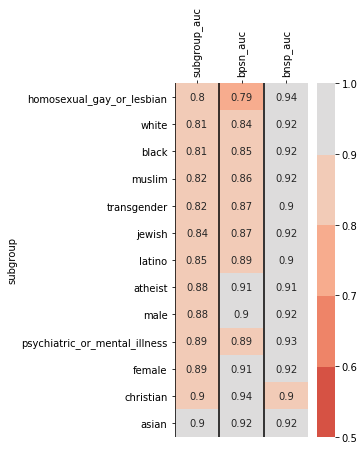

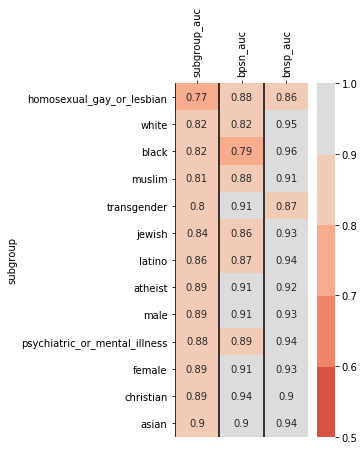

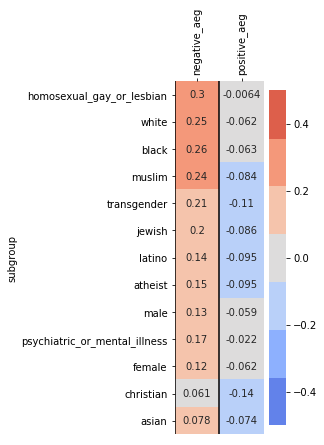

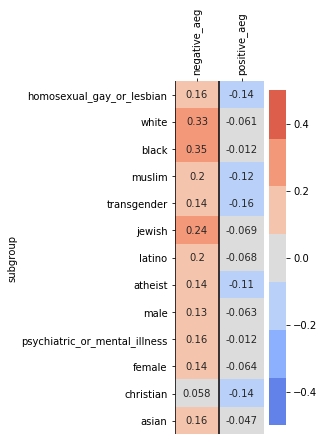

In [ ]:
# Print Civil Comments heatmaps.  Filter identities to only use those which have >= 100
# short comments written about them.
CIVIL_COMMENTS_HEATMAP_IDENTITIES = get_identities_over_n(civil_comments_short_df, 100, civil_comments_identity_terms)
print_auc_heatmap(civil_comments_bias_metrics, CIVIL_COMMENTS_HEATMAP_IDENTITIES, 'Rock:TOXICITY', '/tmp/civil_aucs_1.png')
print_auc_heatmap(civil_comments_bias_metrics, CIVIL_COMMENTS_HEATMAP_IDENTITIES, 'RockV6_2:TOXICITY', '/tmp/civil_aucs_6.png')
print_aeg_heatmap(civil_comments_bias_metrics, CIVIL_COMMENTS_HEATMAP_IDENTITIES, 'Rock:TOXICITY', '/tmp/civil_aegs_1.png')
print_aeg_heatmap(civil_comments_bias_metrics, CIVIL_COMMENTS_HEATMAP_IDENTITIES, 'RockV6_2:TOXICITY', '/tmp/civil_aegs_6.png')

# Print Civil Comments Short Comments heatmaps
print_auc_heatmap(civil_comments_short_bias_metrics, CIVIL_COMMENTS_HEATMAP_IDENTITIES, 'Rock:TOXICITY', '/tmp/civil_short_aucs_1.png')
print_auc_heatmap(civil_comments_short_bias_metrics, CIVIL_COMMENTS_HEATMAP_IDENTITIES, 'RockV6_2:TOXICITY', '/tmp/civil_short_aucs_6.png')
print_aeg_heatmap(civil_comments_short_bias_metrics, CIVIL_COMMENTS_HEATMAP_IDENTITIES, 'Rock:TOXICITY', '/tmp/civil_short_aegs_1.png')
print_aeg_heatmap(civil_comments_short_bias_metrics, CIVIL_COMMENTS_HEATMAP_IDENTITIES, 'RockV6_2:TOXICITY', '/tmp/civil_short_aegs_6.png')

# Print Madlibs heatmaps, using same number of identities as civil comments
num_identities = len(CIVIL_COMMENTS_HEATMAP_IDENTITIES)
MADLIB_HEATMAP_IDENTITIES = madlibs_identity_terms[:num_identities]
print_auc_heatmap(madlibs_bias_metrics, MADLIB_HEATMAP_IDENTITIES, 'Rock:TOXICITY', '/tmp/madlibs_aucs_1.png')
print_auc_heatmap(madlibs_bias_metrics, MADLIB_HEATMAP_IDENTITIES, 'RockV6_2:TOXICITY', '/tmp/madlibs_aucs_6.png')
print_aeg_heatmap(madlibs_bias_metrics, MADLIB_HEATMAP_IDENTITIES, 'Rock:TOXICITY', '/tmp/madlibs_aegs_1.png')
print_aeg_heatmap(madlibs_bias_metrics, MADLIB_HEATMAP_IDENTITIES, 'RockV6_2:TOXICITY', '/tmp/madlibs_aegs_6.png')

In [20]:
# import latexipy as lp

# lp.latexify()  # Change to a serif font that fits with most LaTeX.

# with lp.figure('filename'):  # saves in img/ by default.
#     print_auc_heatmap(civil_comments_bias_metrics, CIVIL_COMMENTS_HEATMAP_IDENTITIES, 'Rock:TOXICITY')


In [64]:
import model_bias_analysis

In [65]:
sns.cubehelix_palette(9, 0, 1, as_cmap=False)

[[0.773680472072477, 0.8792253730455125, 0.9103021444724285],
 [0.6359562561170744, 0.8277288603495724, 0.7778077186577375],
 [0.5411938694830487, 0.7570510025900546, 0.5953759908446334],
 [0.5095488319819432, 0.658545178894183, 0.42571637688076547],
 [0.5146241498220778, 0.5323018644837008, 0.3046847908278071],
 [0.5149343619221521, 0.3896057065263806, 0.24924578864547137],
 [0.47072750264318264, 0.26639465672852164, 0.24635638300149615],
 [0.36206997489526666, 0.16838934527573524, 0.24839595395185524],
 [0.21738280850208047, 0.10319885825470909, 0.20834136015870303]]

In [51]:
sns.color_palette('coolwarm', 9)

[(0.34832334141176474, 0.46571114650980389, 0.88834616294117641),
 (0.48385432959999997, 0.62204984959999998, 0.97480820260000001),
 (0.61931794518823535, 0.74412073476470586, 0.99893091881960783),
 (0.75361061799999995, 0.83023285099999999, 0.96087115700000003),
 (0.86742763508627452, 0.86437659977254899, 0.86260246201960789),
 (0.94734540359999997, 0.79469550479999995, 0.71699050580000001),
 (0.96849974766666669, 0.67397737977254901, 0.55664925604705884),
 (0.93183129659999997, 0.51908552320000001, 0.40647960859999999),
 (0.83936493707843141, 0.32185622094117644, 0.26492398098039216)]

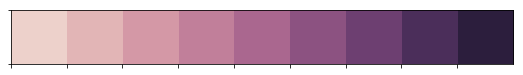

[[0.9312692223325372, 0.8201921796082118, 0.7971480974663592],
 [0.8888663743660877, 0.7106793139856472, 0.7158661451411206],
 [0.8314793143949643, 0.5987041921652179, 0.6530062709235388],
 [0.7588951019517731, 0.49817117746394224, 0.6058723814510268],
 [0.6672565752652589, 0.40671838146419587, 0.5620016466433286],
 [0.5529215689527474, 0.3217924564263954, 0.5093718054521851],
 [0.43082755198027817, 0.24984535814964698, 0.44393960899639856],
 [0.29794615023641036, 0.18145907625614888, 0.35317781405034754],
 [0.1750865648952205, 0.11840023306916837, 0.24215989137836502]]

In [58]:
sns.choose_cubehelix_palette()